In [61]:
DEBUG = False

# Introduction
- Models developed: 
    - SVM, Decision Tree (Ray)
    - KNN, Neural Network (Jamie)
    - Voting classifier combination

# Feature Extraction

### Colour extraction

In [3]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# from skimage import io, color
# from skimage.feature import local_binary_pattern

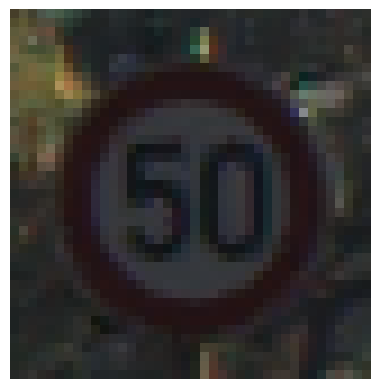

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import extcolors

from colormap import rgb2hex

image_dir = "./Data/train/"
input_name = 'img_005470.jpg' 

img = Image.open(os.path.join(image_dir, input_name))
plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
colors_x = extcolors.extract_from_image(img, tolerance = 12, limit = 12)
colors_x

([((33, 19, 21), 775),
  ((52, 55, 59), 650),
  ((104, 99, 60), 76),
  ((70, 62, 41), 70),
  ((20, 29, 30), 22),
  ((76, 85, 75), 16),
  ((34, 25, 43), 9),
  ((103, 78, 61), 4),
  ((148, 130, 66), 4),
  ((38, 70, 47), 3),
  ((139, 103, 59), 3),
  ((39, 31, 17), 2)],
 1640)

In [26]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df

df_color = color_to_df(colors_x)
df_color

,c_code,occurence
0,#211315,775
1,#34373B,650
2,#68633C,76
3,#463E29,70
4,#141D1E,22
5,#4C554B,16
6,#22192B,9
7,#674E3D,4
8,#948242,4
9,#26462F,3


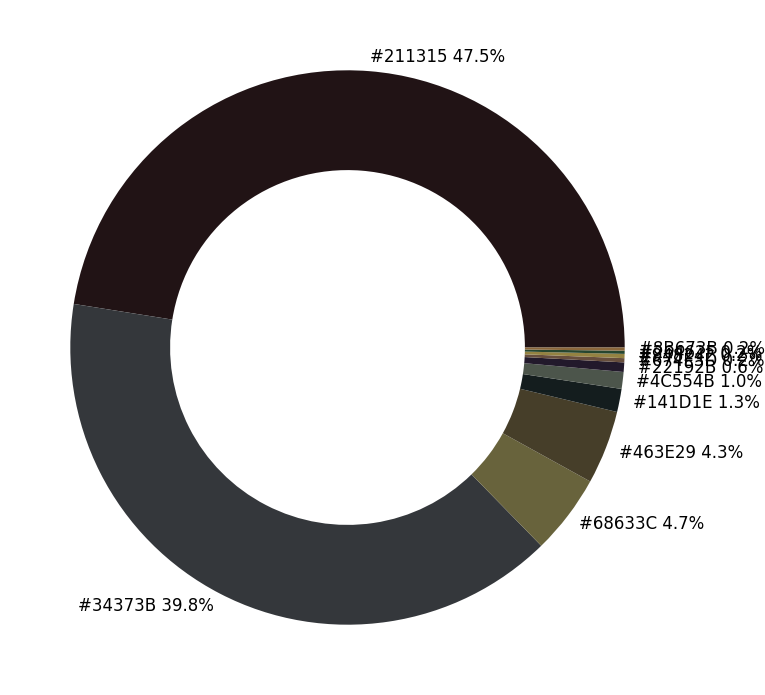

In [27]:
list_color = list(df_color['c_code'])
list_precent = [int(i) for i in list(df_color['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color,
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(90,90),dpi=10)
wedges, text = ax.pie(list_precent,
                      labels= text_c,
                      labeldistance= 1.05,
                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.setp(wedges, width=0.3)

#create space in the center
plt.setp(wedges, width=0.36)

ax.set_aspect("equal")
fig.set_facecolor('white')
plt.show()

In [29]:
import cv2
import numpy as np
from PIL import Image

def classify_sign_color(image_path):
    # Load image
    image = Image.open(image_path)
    image = image.resize((64, 64))  # Resize for consistency
    image_np = np.array(image)

    # Convert to HSV
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Define color ranges in HSV
    red_lower1 = np.array([0, 70, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 70, 50])
    red_upper2 = np.array([180, 255, 255])

    blue_lower = np.array([100, 100, 50])
    blue_upper = np.array([140, 255, 255])

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([35, 255, 255])

    # Create masks
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = red_mask1 + red_mask2

    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

    # Count the number of pixels in each mask
    red_count = np.sum(red_mask > 0)
    blue_count = np.sum(blue_mask > 0)
    yellow_count = np.sum(yellow_mask > 0)

    # Determine dominant color
    counts = {'red': red_count, 'blue': blue_count, 'yellow': yellow_count}
    dominant_color = max(counts, key=counts.get)

    print(f"Dominant color: {dominant_color}")
    return dominant_color

# Example usage
image_dir = "./Data/train/"
input_name = 'img_005470.jpg' 

image_path = os.path.join(image_dir, input_name)
classify_sign_color(image_path)

Dominant color: yellow


'yellow'

In [63]:
# read train data
train_metadata = pd.read_csv('Data/train/train_metadata.csv', index_col="id")
train_color_hist = pd.read_csv('Data/train/Features/color_histogram.csv')
train_hog_pca = pd.read_csv('Data/train/Features/hog_pca.csv')
train_additional_features = pd.read_csv('Data/train/Features/additional_features.csv')

In [64]:
# choose data to be used
train_data = [train_hog_pca, train_color_hist]
# drop duplicate image path column
train_data = [col.drop(columns='image_path') for col in train_data]
# combine all data to make a dataframe
train_data_df = pd.concat(train_data, axis=1)
# add index
train_data_df.index = train_metadata.index

if DEBUG:
    print(train_data_df)

#### Split Train data into train/test for model testing purposes

In [65]:
# split train data into train and test, for development purposes 
X_train, X_test, y_train, y_test = train_test_split(
    train_data_df, train_metadata["ClassId"], 
    test_size=0.2,                          # Proportion of the data to include in the test split
    stratify=train_metadata["ClassId"]      # Stratifies data
)

if DEBUG:
    print(X_train.index[0])
    print(y_train.index[0])
    
    print(f"X_train: \n{X_train}")
    print(f"X_test: \n{X_test}")
    print(f"y_train: \n{y_train}")
    print(f"y_test: \n{y_test}")

#### Import Testing Data

In [66]:
# read test data
test_metadata = pd.read_csv('Data/test/test_metadata.csv', index_col="id")
test_color_hist = pd.read_csv('Data/test/Features/color_histogram.csv')
test_hog_pca = pd.read_csv('Data/test/Features/hog_pca.csv')
test_additional_features = pd.read_csv('Data/test/Features/additional_features.csv')

In [67]:
# choose data to be used
test_data = [test_hog_pca, test_color_hist]
# drop duplicate image path column
test_data = [col.drop(columns='image_path') for col in test_data]
# make dataframe
test_data_df = pd.concat(test_data, axis=1)
# add index
test_data_df.index = test_metadata.index

if DEBUG:
    print(test_data_df)

# Visualising the data

In [ ]:
image_dir = "./Data/train/"

# Function to load an image
def load_image(image_path):
    img = Image.open(os.path.join(image_dir, image_path))
    img = img.resize((30, 30))  # make the image smaller
    return np.array(img)


In [13]:
img = load_image("img_005470.jpg")
print(img.shape)

(30, 30, 3)


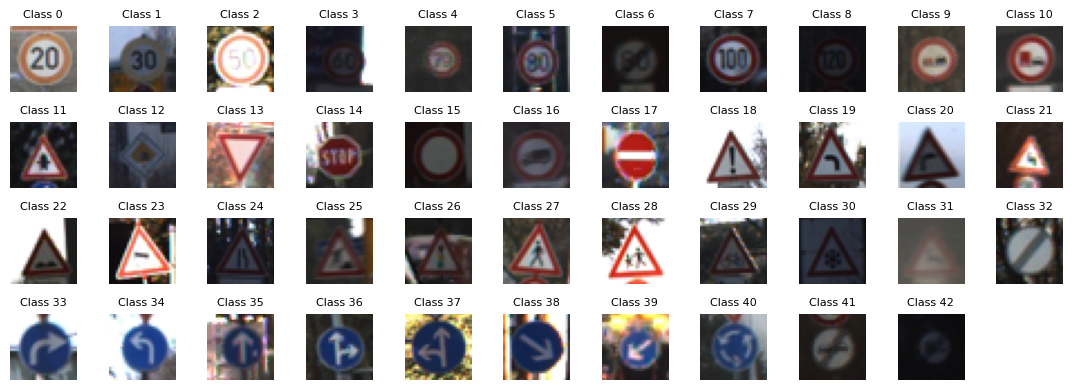

In [83]:
# Function to plot one image per class in a 11-column grid
def plot_images_per_class(df):
    num_classes = 43
    columns = 11
    rows = (num_classes + columns - 1) // columns  # Calculate number of rows needed

    plt.figure(figsize=(columns, rows))  # Adjust figure size

    for class_label in range(num_classes):
        class_df = df[df['ClassId'] == class_label]

        img_path = train_metadata['image_path'][class_df.index[18]]
    
        img = load_image(img_path)

        plt.subplot(rows, columns, class_label + 1)
        plt.imshow(img)
        plt.title(f"Class {class_label}", fontsize=8)
        plt.axis('off') 

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_images_per_class(train_metadata)

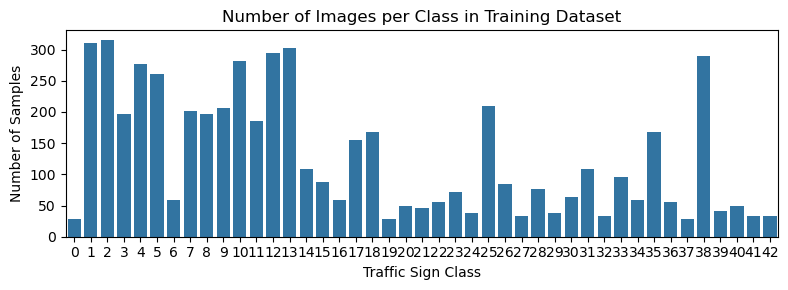

In [70]:
import seaborn as sns

# Count how many examples per class
class_counts = train_metadata['ClassId'].value_counts().sort_index()

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'ClassId': class_counts.index,
    'Count': class_counts.values,
})

# Plot
plt.figure(figsize=(8, 3))
sns.barplot(data=plot_df, x='ClassId', y='Count')


plt.title('Number of Images per Class in Training Dataset')
plt.xlabel('Traffic Sign Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

# ML Models

## K Nearest Neighbours

In [71]:
# train a KNN model

from sklearn.neighbors import KNeighborsClassifier

KNNModel = KNeighborsClassifier(n_neighbors=1)
KNNModel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [72]:
# test model on test set, calculate accuracy
y_pred = KNNModel.predict(X_test)
knn_accuracy = accuracy_score(y_pred, y_test)

print(f"Accuracy: {knn_accuracy * 100:.2f}%")

Accuracy: 83.61%


In [73]:
# display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(cm)
# matrix.plot()
# plt.gcf().set_size_inches(15, 15)
# plt.title('Confusion Matrix')
# plt.show()


In [74]:
knn_predictions = KNNModel.predict(test_data_df)

# Create DataFrame with index as 'id' and prediction as 'ClassId'
result_df = pd.DataFrame({'ClassId': knn_predictions}, index=test_data_df.index)

# Write to CSV
result_df.to_csv("result_knn.csv", index=True)

# Logistic Regression

In [75]:
# logistic regression
from sklearn.linear_model import LogisticRegression

LGRModel = LogisticRegression()
#train the model using the training set
LGRModel.fit(X_train,y_train)

#test the model using the testiong set
lgr_accuracy = LGRModel.score(X_test,y_test)
print(f"Accuracy: {lgr_accuracy * 100:.2f}%")

Accuracy: 80.78%


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# First, scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Then, fit the logistic regression model
LGRModel = LogisticRegression()  
LGRModel.fit(X_train_scaled, y_train)

# Evaluate
lgr_accuracy = LGRModel.score(X_test_scaled, y_test)
print(f"Accuracy: {lgr_accuracy * 100:.2f}%")

Accuracy: 72.40%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
print(X_train_scaled)

[[0.42967179 0.39940025 0.56628994 ... 0.         0.         0.        ]
 [0.52384353 0.5471116  0.86254478 ... 0.         0.         0.        ]
 [0.20974373 0.21787736 0.45519816 ... 0.         0.         0.        ]
 ...
 [0.09378206 0.19237423 0.42119827 ... 0.         0.         0.        ]
 [0.3111906  0.34008705 0.72314434 ... 0.         0.         0.        ]
 [0.50543416 0.47312226 0.55596598 ... 0.04732003 0.03269305 0.07053103]]


In [78]:
lgr_predictions = LGRModel.predict(test_data_df)

# Create DataFrame with index as 'id' and prediction as 'ClassId'
result_df = pd.DataFrame({'ClassId': lgr_predictions}, index=test_data_df.index)

# Write to CSV
result_df.to_csv("result_lgr.csv", index=True)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [79]:
result = pd.DataFrame(columns=["knn", "lgr"])
result["knn"] = knn_predictions
result["lgr"] = lgr_predictions

result.to_csv("result.csv", index=False)

# Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier(random_state=0)
RFModel.fit(X_train, y_train)

#test the model using the testiong set
rf_accuracy = RFModel.score(X_test,y_test)
print(f"Accuracy: {rf_accuracy * 100:.2f}%")


Accuracy: 77.96%
